In [1]:
# %load_ext autoreload
# %autoreload 2
# %matplotlib qt
import sys; sys.path.insert(0, '../') 
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import mne

from invert.forward import get_info, create_forward_model
from invert.util import pos_from_forward
from invert.evaluate import eval_auc

pp = dict(surface='white', hemi='both', verbose=0)

In [2]:
info = get_info(kind='biosemi64')
fwd = create_forward_model(info=info, sampling='ico3')
pos = pos_from_forward(fwd)
leadfield = fwd["sol"]["data"]
n_chans, n_dipoles = leadfield.shape

source_model = fwd['src']
vertices = [source_model[0]['vertno'], source_model[1]['vertno']]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    6.7s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    7.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s finished


# Simulate

In [3]:
from invert.solvers.esinet import generator

sim_params = dict(
    use_cov=False,
    return_mask=False,
    batch_repetitions=1,
    batch_size=1,
    n_sources=15,
    n_orders=(0, 3),
    snr_range=(1e99, 2e99),
    n_timecourses=200,
    n_timepoints=200,
    scale_data=False, 
    add_forward_error=False,
    forward_error=0.3)

gen = generator(fwd, **sim_params)

No projector specified for this dataset. Please consider the method self.add_proj.


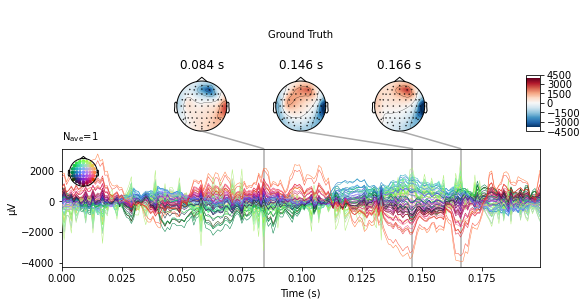

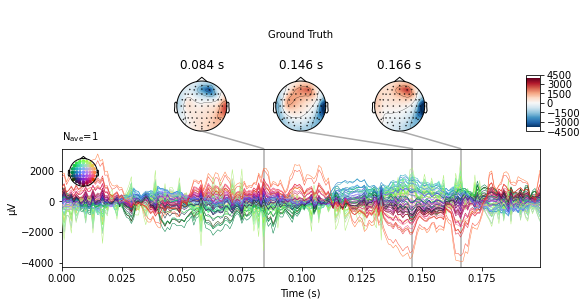

In [14]:
x, y = gen.__next__()

tmin = 0
tstep = 1/info["sfreq"]
subject = "fsaverage"
evoked = mne.EvokedArray(x[0].T, info, tmin=tmin)
stc = mne.SourceEstimate(y[0].T, vertices, tmin=tmin, tstep=tstep, 
                        subject=subject, verbose=0)

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, "Ground Truth", 'title',
               font_size=14)
evoked.plot_joint(title="Ground Truth")

# Solve

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


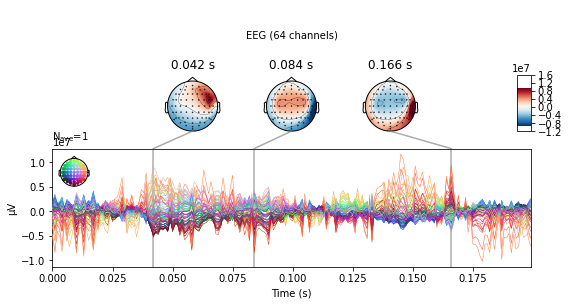

r =  0.37049547813670725
L1 =  2.130319987631699
auc:  0.7915625


Using control points [4.86692356e-05 1.03668153e-04 1.26023909e-03]
Using control points [0.         0.00188123 0.08127228]
Using control points [0.         0.00188123 0.08127228]


In [15]:
# from invert import Solver
# solver_lstm = Solver("LSTM")
# solver_lstm.make_inverse_operator(fwd, evoked,  n_sources=15, n_orders=(0, 3), epochs=2000, n_lstm_units=512, n_dense_units=500)
# solver_lstm.save("LSTM_big")
solver_lstm.epsilon=0.1
stc_ = solver_lstm.apply_inverse_operator(evoked)

# stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver_lstm.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
evoked_.plot_joint()

print("r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])
print("L1 = ",  np.linalg.norm(stc_.data, ord=1))
print("auc: ", eval_auc(stc.data[:, 0], stc_.data[:, 0], pos))

In [15]:
from invert import Solver
solver_lstm = Solver("LSTM")
solver_lstm.make_inverse_operator(fwd, evoked,  n_sources=15, n_orders=(0, 3), epochs=2000, n_lstm_units=512, n_dense_units=500)
solver_lstm.save("LSTM_big")
# stc_ = solver_lstm.apply_inverse_operator(evoked)

# # stc_.data /= abs(stc_.data).max()
# brain = stc_.plot(**pp)
# brain.add_text(0.1, 0.9, solver_lstm.name, 'title',
#                font_size=14)

# evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
# evoked_.plot_joint()

# print("r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])
# print("L1 = ",  np.linalg.norm(stc_.data, ord=1))
# print("auc: ", eval_auc(stc.data[:, 0], stc_.data[:, 0], pos))

Create Generator:..
Build Model:..
Train Model:..
Epoch 1/2000
10/10 [==============================] - 9s 596ms/step - loss: -0.0710 - val_loss: -0.1225
Epoch 2/2000
10/10 [==============================] - 6s 592ms/step - loss: -0.1296 - val_loss: -0.1483
Epoch 3/2000
10/10 [==============================] - 4s 444ms/step - loss: -0.1549 - val_loss: -0.1611
Epoch 4/2000
10/10 [==============================] - 4s 425ms/step - loss: -0.1709 - val_loss: -0.1702
Epoch 5/2000
10/10 [==============================] - 5s 528ms/step - loss: -0.1847 - val_loss: -0.1820
Epoch 6/2000
10/10 [==============================] - 5s 503ms/step - loss: -0.1954 - val_loss: -0.1905
Epoch 7/2000
10/10 [==============================] - 6s 601ms/step - loss: -0.2049 - val_loss: -0.1947
Epoch 8/2000
10/10 [==============================] - 5s 474ms/step - loss: -0.2086 - val_loss: -0.2011
Epoch 9/2000
10/10 [==============================] - 5s 508ms/step - loss: -0.2148 - val_loss: -0.2059
Epoch 10/2000


INFO:tensorflow:Assets written to: LSTM_big\LSTM_1\assets


INFO:tensorflow:Assets written to: LSTM_big\LSTM_1\assets


INFO:tensorflow:Assets written to: ram://9741fa96-d13e-4a4a-914a-2faaf4ac73ba/assets


INFO:tensorflow:Assets written to: ram://9741fa96-d13e-4a4a-914a-2faaf4ac73ba/assets


In [22]:
from invert import Solver
solver_lstm = Solver("CovCNN")
solver_lstm.make_inverse_operator(fwd, evoked,  n_sources=15, n_orders=(0, 3), epochs=2000, n_filters=256)
# solver_lstm.save("CovCNN_big")
# solver_lstm.epsilon=0.25
# stc_ = solver_lstm.apply_inverse_operator(evoked)
# # stc_.data /= abs(stc_.data).max()
# brain = stc_.plot(**pp)
# brain.add_text(0.1, 0.9, solver_lstm.name, 'title',
#                font_size=14)

# evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info).set_eeg_reference("average", projection=True)
# evoked_.plot_joint()

# print("r = ", pearsonr(abs(stc.data).mean(axis=-1), abs(stc_.data).mean(axis=-1))[0])
# print("L1 = ",  np.linalg.norm(stc_.data, ord=1))
# print("auc: ", eval_auc(stc.data[:, 0], stc_.data[:, 0], pos))

Create Generator:..
Build Model:..
Train Model:..
Epoch 1/2000
10/10 [==============================] - 1s 90ms/step - loss: -0.0878 - cosine_similarity: 0.0878 - val_loss: -0.0736 - val_cosine_similarity: 0.0736
Epoch 2/2000
10/10 [==============================] - 2s 53ms/step - loss: -0.1045 - cosine_similarity: 0.1045 - val_loss: -0.1034 - val_cosine_similarity: 0.1034
Epoch 3/2000
10/10 [==============================] - 3s 51ms/step - loss: -0.1243 - cosine_similarity: 0.1243 - val_loss: -0.1203 - val_cosine_similarity: 0.1203
Epoch 4/2000
10/10 [==============================] - 3s 58ms/step - loss: -0.1405 - cosine_similarity: 0.1405 - val_loss: -0.1333 - val_cosine_similarity: 0.1333
Epoch 5/2000
10/10 [==============================] - 3s 58ms/step - loss: -0.1547 - cosine_similarity: 0.1547 - val_loss: -0.1460 - val_cosine_similarity: 0.1460
Epoch 6/2000
10/10 [==============================] - 3s 60ms/step - loss: -0.1640 - cosine_similarity: 0.1640 - val_loss: -0.1558 - va

KeyboardInterrupt: 

In [6]:
from invert import Solver

activation_functions = ["tanh",]
output_activations = ["linear"]
n_dense_units = [100, 300, 500]
n_filters = [128, 512]
n_dense_layers = [2,]

epochs = 100
n_sources = 15
n_orders = (0,3)
dict_list = []
histories = []
for dense_layer in n_dense_layers:
    for activation_function in activation_functions:
        for output_activation in output_activations:
            for n_dense_unit in n_dense_units:
                for n_filter in n_filters:
                    solver_lstm = Solver("CovCNN")
                    solver_lstm.make_inverse_operator(fwd, evoked, 
                            n_sources=n_sources, n_orders=n_orders, 
                            epochs=epochs, n_filters=n_filter, n_dense_units=n_dense_unit, 
                            output_activation=output_activation, 
                            activation_function=activation_function, dense_layers=dense_layer)
                    history = solver_lstm.history
                    val_loss = history.history["val_loss"][-1]
                    d = dict(activation_function=activation_function, output_activation=output_activation, n_dense_unit=n_dense_unit, n_filter=n_filter, dense_layer=dense_layer, val_loss=val_loss)
                    dict_list.append(d)
                    histories.append(history)


Create Generator:..
Build Model:..
Train Model:..
Epoch 1/100
10/10 [==============================] - 6s 81ms/step - loss: -0.0668 - val_loss: -0.0730
Epoch 2/100
10/10 [==============================] - 2s 40ms/step - loss: -0.0901 - val_loss: -0.0897
Epoch 3/100
10/10 [==============================] - 2s 46ms/step - loss: -0.1067 - val_loss: -0.1054
Epoch 4/100
10/10 [==============================] - 2s 39ms/step - loss: -0.1209 - val_loss: -0.1206
Epoch 5/100
10/10 [==============================] - 2s 38ms/step - loss: -0.1346 - val_loss: -0.1336
Epoch 6/100
10/10 [==============================] - 2s 50ms/step - loss: -0.1457 - val_loss: -0.1434
Epoch 7/100
10/10 [==============================] - 2s 35ms/step - loss: -0.1571 - val_loss: -0.1534
Epoch 8/100
10/10 [==============================] - 2s 35ms/step - loss: -0.1659 - val_loss: -0.1619
Epoch 9/100
10/10 [==============================] - 2s 37ms/step - loss: -0.1738 - val_loss: -0.1690
Epoch 10/100
10/10 [============

In [7]:
import pandas as pd
df = pd.DataFrame(dict_list).sort_values("val_loss")

# df.to_csv("C:/Users/Lukas/Desktop/covcnn_eval.csv")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df)

,activation_function,output_activation,n_dense_unit,n_filter,dense_layer,val_loss
5,tanh,linear,500,512,2,-0.329052
4,tanh,linear,500,128,2,-0.325736
2,tanh,linear,300,128,2,-0.325471
3,tanh,linear,300,512,2,-0.312016
0,tanh,linear,100,128,2,-0.267575
1,tanh,linear,100,512,2,-0.261880


<AxesSubplot:xlabel='n_filter', ylabel='val_loss'>

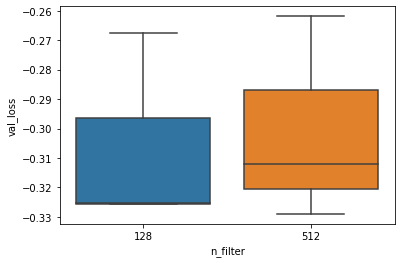

In [9]:
import seaborn as sns
sns.boxplot(x="n_filter", y="val_loss", data=df)

In [11]:
import pingouin as pg
aov = pg.anova(data=df, dv="val_loss", between=["dense_layer", "n_dense_unit", "n_filter"])


# ph = pg.pairwise_tukey(data=df, dv="val_loss", between=["activation_function", "n_dense_unit", "n_filter"])


display(aov)
# print("\n\n")
# display(ph)


c:\Users\Lukas\Envs\invertenv\lib\site-packages\statsmodels\regression\linear_model.py:1687: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


ValueError: must have at least one row in constraint matrix